In [67]:
import pandas as pd
import time
import requests
import json
import math

data = pd.read_json("https://data.nsw.gov.au/data/api/3/action/datastore_search?resource_id=2776dbb8-f807-4fb2-b1ed-184a6fc2c8aa&limit=10000")
data = pd.json_normalize(data.result.records)
data = data.query("likely_source_of_infection != 'Overseas'")
data = data[["notification_date", "lga_code19"]]
data.columns = ["date", "code"]
data.date = pd.to_datetime(data.date)
data["cases"] = [1] * len(data)

data = data.groupby(["date", "code"]).sum().reset_index()
data.code = data.code.astype("int")
data.dropna(inplace=True)
data.sort_values("date", inplace=True)

data.describe(datetime_is_numeric=True)

act_data = pd.read_csv("./actCases.csv")
act_data.date = pd.to_datetime(act_data.date, format="%d/%m/%Y")
act_data.sort_values("date", inplace=True)
act_data["code"] = 89399

act_data.describe(datetime_is_numeric=True)

data = pd.concat([data, act_data], ignore_index=True)
date_start = data.date.min()
date_end = data.date.max()
date_length = (date_end - date_start).days

data_chart = pd.DataFrame(columns=["date", "code", "cases"])

count = 0
print("date being processed:")
while date_start + pd.Timedelta(count, unit="d") <= date_end:
    date_current = date_start + pd.Timedelta(count, unit="d")    
    print(date_current, end="\r")
    for code in data.code.unique():
        data_temp = data[(data.date == date_current) & (data.code == code)]
        if len(data_temp) == 0:
            data_chart.loc[len(data_chart)] = [date_current, code, 0]
        else:
            data_chart.loc[len(data_chart)] = [date_current, code, data_temp.iat[0, 2]]
    count = count + 1
print("date processing completed")

timer = time.time()
interval = 1
print("processing recent cases ...", end="\r")
for i, indice in enumerate(data_chart.index):
    data_temp = data_chart[(data_chart.code == data_chart.at[indice, "code"]) & (data_chart.date > data_chart.at[indice, "date"] - pd.Timedelta("14 days")) & (data_chart.date <= data_chart.at[indice, "date"])]
    data_chart.at[indice, "recent"] = data_temp.cases.sum()
    if time.time() - interval > timer:
        interval = interval + 1
        print(f"processing recent cases ... {(i + 1) / len(data_chart):.1%}", end="\r")
print("processing recent cases ... complete")

data_chart.to_csv("./cases.csv", index=False)

,date,code,cases
count,1568,1568.000000,1568.000000
mean,2020-09-07 17:54:29.387755264,14508.616071,2.343112
min,2020-03-02 00:00:00,10050.000000,1.000000
25%,2020-04-01 00:00:00,11650.000000,1.000000
50%,2020-07-24 00:00:00,14700.000000,1.000000
75%,2021-01-01 00:00:00,16700.000000,2.000000
max,2021-07-20 00:00:00,18500.000000,75.000000
std,NaN,2577.371746,4.659936


In [68]:
data_pop = pd.read_csv("./lga_pop.csv")
data_pop = data_pop.query("POP_COMP == 10 & TIME == 2020")
data_pop = data_pop[["LGA_2020", "Region", "Value"]]
data_pop.columns = ["code", "name", "pop"]
data_pop = data_pop[(data_pop["code"].apply(lambda x: len(str(x)) == 5)) & (data_pop["code"].apply(lambda x: (str(x)[0] == "1") or (str(x)[0]) == "8" ))]
data_pop["name"] = data_pop["name"].apply(lambda x: x[:x.find(" (")] if x.find(" (") > -1 else "ACT" if x == "Unincorporated ACT" else x)

codes = data_pop.code.unique()
names = data_pop.name.unique()

df = pd.DataFrame(columns=["code", "name", "pop", "cases"])
df["code"] = codes
df["name"] = names

for i in df.index:
    try:
        pop = data_pop[data_pop.code == df.at[i, "code"]].iat[0, 2]
    except:
        pop = 0
    df.at[i, "pop"] = pop
    df.at[i, "cases"] = data_chart[data_chart["code"] == df.at[i, "code"]].cases.sum()

data_distance = pd.read_csv("./dataDistance.csv")
data_distance["lng"] = data_distance["location"].apply(lambda x: float(x.split(",")[0]))
data_distance["lat"] = data_distance["location"].apply(lambda x: float(x.split(",")[1]))

for i in df.index:
    df.at[i, "area"] = data_distance[data_distance["code"] == df.at[i, "code"]].iat[0, 2]
    df.at[i, "lng"] = data_distance[data_distance["code"] == df.at[i, "code"]].iat[0, 4]
    df.at[i, "lat"] = data_distance[data_distance["code"] == df.at[i, "code"]].iat[0, 5]
    df.at[i, "density"] = df.at[i, "pop"] / df.at[i, "area"]
    df.at[i, "location"] = data_distance[data_distance["code"] == df.at[i, "code"]].iat[0, 3]

start = time.time()
interval = 1
print("processing driving times ...", end="\r")
for j, i in enumerate(df.index):
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/151.179428,-33.947346;{df.at[i, 'location']}?overview=false")
    routes = json.loads(r.content)
    try:
        duration = routes.get("routes")[0]["duration"]
    except:
        duration = float("null")
    df.at[i, "duration"] = duration
    if time.time() - interval > start:
        interval = interval + 1
        print(f"processing driving times ... {(j + 1) / len(df):.1%}", end="\r")
print("processing driving times ... complete")

df.to_csv("./data_chart.csv", index=False)
df

processing driving times ... complete


,code,name,pop,cases,area,lng,lat,density,location,duration
0,16550,Randwick,156619,128,36.3311,151.240209,-33.943230,4310.879660,"151.24020901452275,-33.94323039472664",743.6
1,14220,Inverell,17780,0,9408.4666,151.074227,-29.417251,1.889787,"151.07422748538636,-29.417251320651523",32110.8
2,18020,Warrumbungle Shire,9209,0,12372.1201,149.404709,-31.461388,0.744335,"149.40470890698666,-31.461387790370384",23778.2
3,11250,Broken Hill,17269,2,170.1153,141.479272,-31.944029,101.513503,"141.47927205136557,-31.94402940763503",52468.1
4,12380,Cumberland,242674,214,71.5511,150.987615,-33.842559,3391.618018,"150.9876147017707,-33.84255859420105",1993.2
...,...,...,...,...,...,...,...,...,...,...
125,11730,Clarence Valley,51730,0,10428.6803,152.751456,-29.681089,4.960359,"152.75145556946865,-29.68108914166177",31123.8
126,18450,Wollongong,219798,25,683.9860,150.837307,-34.368675,321.348683,"150.83730721065484,-34.368675447573644",3569.0
127,14600,Lachlan,6089,0,14968.2538,146.991276,-32.918627,0.406794,"146.99127555816057,-32.91862717689199",26328.5
128,15050,Maitland,87395,4,391.5087,151.549707,-32.710811,223.226202,"151.54970728552627,-32.71081144780645",9039.5


<AxesSubplot:xlabel='combo2', ylabel='cases'>

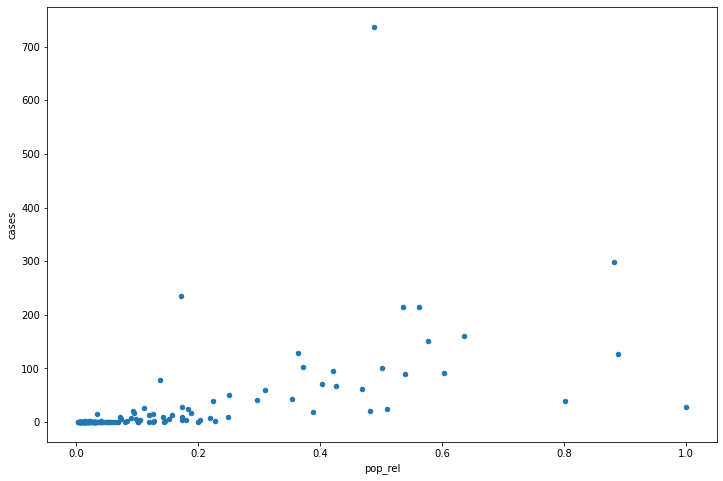

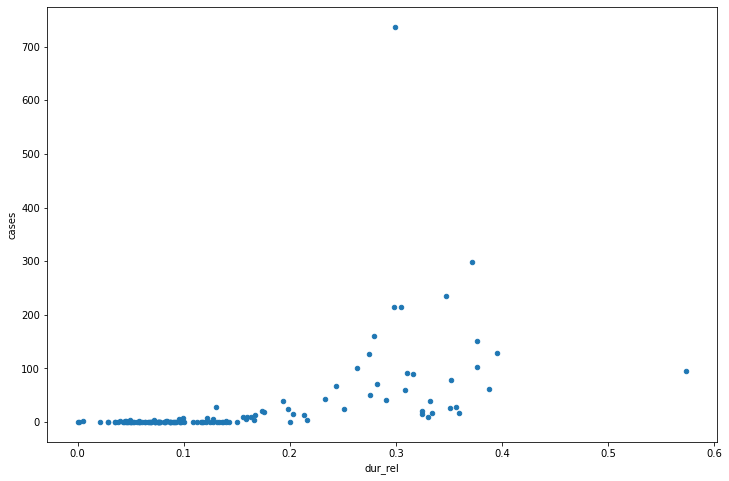

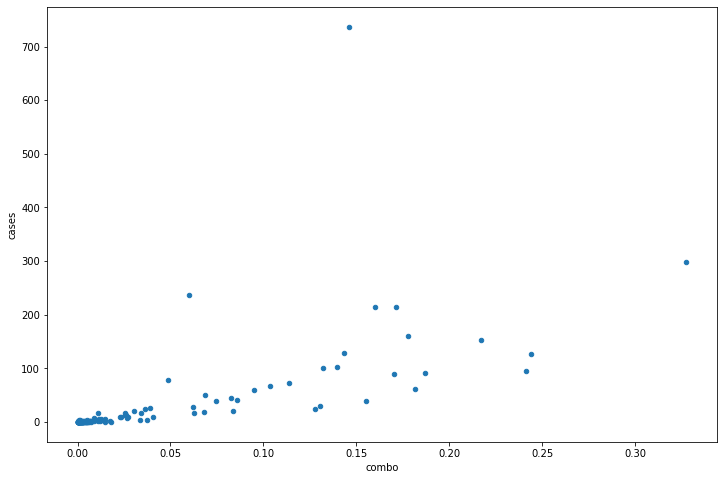

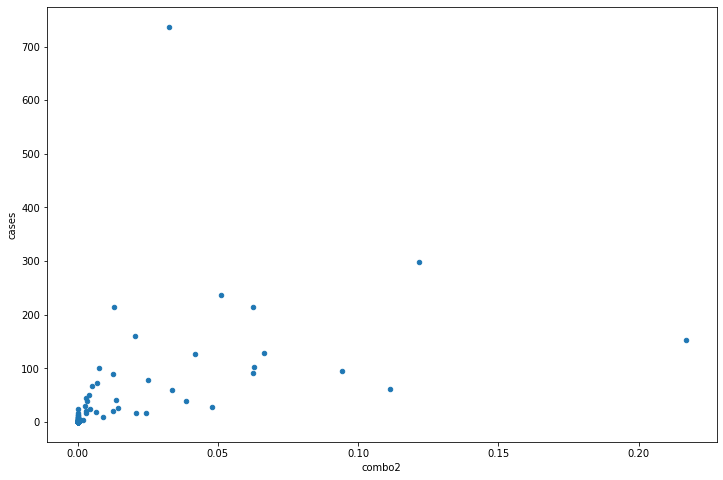

In [117]:
df_plot = df.query("duration > 0 & pop > 0")
df_plot["pop"] = df_plot["pop"].astype("int")
df_plot["cases"] = df_plot["cases"].astype("int")
max_pop = df_plot["pop"].max()
max_density = df_plot["density"].max()
max_dur = df_plot["duration"].apply(math.log).max()
df_plot["pop_rel"] = df_plot["pop"] / max_pop
df_plot["den_rel"] = df_plot["density"] / max_density
df_plot["pop_test"] = df_plot["pop_rel"] * df_plot["den_rel"]
df_plot["dur_rel"] = 1 - df_plot["duration"].apply(math.log) / max_dur
df_plot["combo"] = df_plot["pop_rel"] * df_plot["dur_rel"]
df_plot["combo2"] = df_plot["pop_test"] * df_plot["dur_rel"]

df_plot.to_csv("data_simple.csv", index=False)

df_plot.plot.scatter("pop_rel", "cases", figsize=(12, 8))
df_plot.plot.scatter("dur_rel", "cases", figsize=(12, 8))
df_plot.plot.scatter("combo", "cases", figsize=(12, 8))
df_plot.plot.scatter("combo2", "cases", figsize=(12, 8))